# Affine transforms
Here we compare performance of affine transforms implemented in [cupy](https://cupy.dev), [scipy](https://scipy.org) and clEsperanto

**Note:** benchmarking results vary heavily depending on image size, kernel size, used operations, parameters and used hardware. Use this notebook to adapt it to your use-case scenario and benchmark on your target hardware. If you have different scenarios or use-cases, you are very welcome to submit your notebook as pull-request!

In [1]:
import pyclesperanto_prototype as cle

# to measure kernel execution duration properly, we need to set this flag. It will slow down exection of workflows a bit though
cle.set_wait_for_kernel_finish(True)

# selet a GPU with the following in the name. This will fallback to any other GPU if none with this name is found
cle.select_device('RTX')

<NVIDIA GeForce RTX 3050 Ti Laptop GPU on Platform: NVIDIA CUDA (1 refs)>

In [2]:
from skimage.io import imread, imshow
image = imread('../data/Haase_MRT_tfl3d1.tif')

(120, 160, 160)

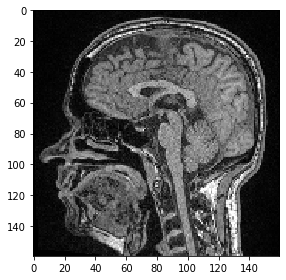

In [3]:
imshow(image[60])
image.shape

In [4]:
import numpy as np

# scaling by factor 1 / s
s = 0.5
matrix = np.asarray([
    [s, 0, 0, 0],
    [0, s, 0, 0],
    [0, 0, s, 0],
    [0, 0, 0, 1],
])
output_shape = tuple((np.asarray(image.shape) / s).astype(int))
print(output_shape)


(240, 320, 320)


## cupy

cupy affine transform duration: 2.615372896194458
cupy affine transform duration: 0.46410441398620605
cupy affine transform duration: 0.463104248046875
cupy affine transform duration: 0.4631040096282959
cupy affine transform duration: 0.4631037712097168
cupy affine transform duration: 0.463104248046875
cupy affine transform duration: 0.4631040096282959
cupy affine transform duration: 0.4631049633026123
cupy affine transform duration: 0.46410489082336426
cupy affine transform duration: 0.4631030559539795


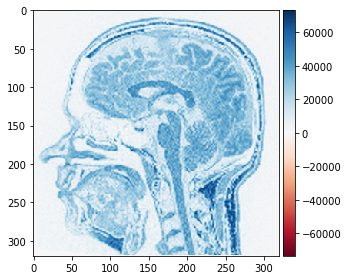

In [5]:
import time
import cupy
from cupyx.scipy import ndimage as ndi

cuda_image = cupy.asarray(image)

cuda_scaled = cupy.ndarray(output_shape)
for i in range(0, 10):
    start_time = time.time()
    ndi.affine_transform(cuda_image, cupy.asarray(matrix), output=cuda_scaled, output_shape=output_shape)
    cupy.cuda.stream.get_current_stream().synchronize() # we need to wait here to measure time properly
    print("cupy affine transform duration: " + str(time.time() - start_time))
          
result = cupy.asnumpy(cuda_scaled)
imshow(result[120])

## clEsperanto

clEsperanto affine transform duration: 0.325070858001709
clEsperanto affine transform duration: 0.0059926509857177734
clEsperanto affine transform duration: 0.005481243133544922
clEsperanto affine transform duration: 0.005229949951171875
clEsperanto affine transform duration: 0.005207538604736328
clEsperanto affine transform duration: 0.005212545394897461
clEsperanto affine transform duration: 0.005178689956665039
clEsperanto affine transform duration: 0.005192995071411133
clEsperanto affine transform duration: 0.005285024642944336
clEsperanto affine transform duration: 0.005232572555541992


C:\Users\rober\miniconda3\envs\bio1\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


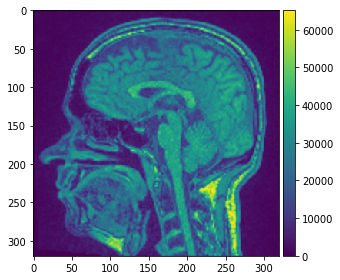

In [6]:
ocl_image = cle.push(image)

ocl_scaled = cle.create(output_shape)
for i in range(0, 10):
    start_time = time.time()
    cle.affine_transform(ocl_image, ocl_scaled, transform=np.linalg.inv(matrix), linear_interpolation=True)
    print("clEsperanto affine transform duration: " + str(time.time() - start_time))

result = cle.pull(ocl_scaled)
imshow(result[120])

## Scipy

scipy affine transform duration: 7.142598867416382
scipy affine transform duration: 7.073591470718384
scipy affine transform duration: 6.876546859741211
scipy affine transform duration: 6.865544080734253
scipy affine transform duration: 6.875546932220459
scipy affine transform duration: 6.8615429401397705
scipy affine transform duration: 6.608499765396118
scipy affine transform duration: 6.803070545196533
scipy affine transform duration: 6.62677526473999
scipy affine transform duration: 6.507538795471191


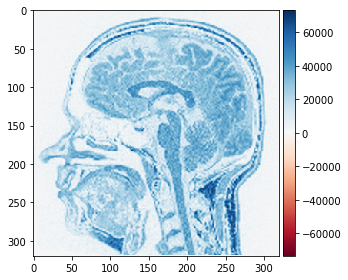

In [7]:
import time
from scipy import ndimage as sndi

scaled = np.ndarray(output_shape)
for i in range(0, 10):
    start_time = time.time()
    sndi.affine_transform(image, matrix, output=scaled, output_shape=output_shape)
    print("scipy affine transform duration: " + str(time.time() - start_time))

imshow(scaled[120])